In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import torch
import numpy as np
from torch import nn
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

<b><h2><center>Подготовка Данных</center></h2></b>

In [3]:
class LoadData:
    def __init__(self, path):
        dirs = os.listdir(path)
        filenames = {0: [path + dirs[0] + '/' + filename for filename in os.listdir(path + dirs[0])],
                     1: [path + dirs[1] + '/' + filename for filename in os.listdir(path + dirs[1])]}

        X_data, y_data = self.read_images(filenames)
        train, valid = self.split_data(X_data, y_data)
        self.train_dataset = self.cvt_to_torch(train[0], train[1])
        self.valid_dataset = self.cvt_to_torch(valid[0], valid[1])

    def read_images(self, filenames):
        X, y = [], []
        for label in filenames.keys():
            for filename in tqdm(filenames[label]):
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
                img = img.transpose(2, 0, 1)
                X.append(img)
                y.append(np.expand_dims(label, 0))
        return np.array(X), np.array(y).astype(np.float32)

    def split_data(self, X_data, y_data):
        X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, shuffle=True)
        return (X_train, y_train), (X_valid, y_valid)

    def cvt_to_torch(self, X, y):
        dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        return dataset

    def get_dataloadet(self):
        train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True)
        valid_loader = DataLoader(self.valid_dataset, batch_size=1, shuffle=True)
        return train_loader, valid_loader

    def __del__(self):
        print('object deleted!')


path = '/content/drive/MyDrive/dataset/'
dataloader = LoadData(path)
train_loader, valid_loader = dataloader.get_dataloadet()
del dataloader

for X, y in train_loader:
    print(X.size(), y.size())
    break

  0%|          | 0/2871 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

object deleted!
torch.Size([16, 3, 119, 119]) torch.Size([16, 1])


<b><h2><center>Демонстрация входа модели</center></h2></b>

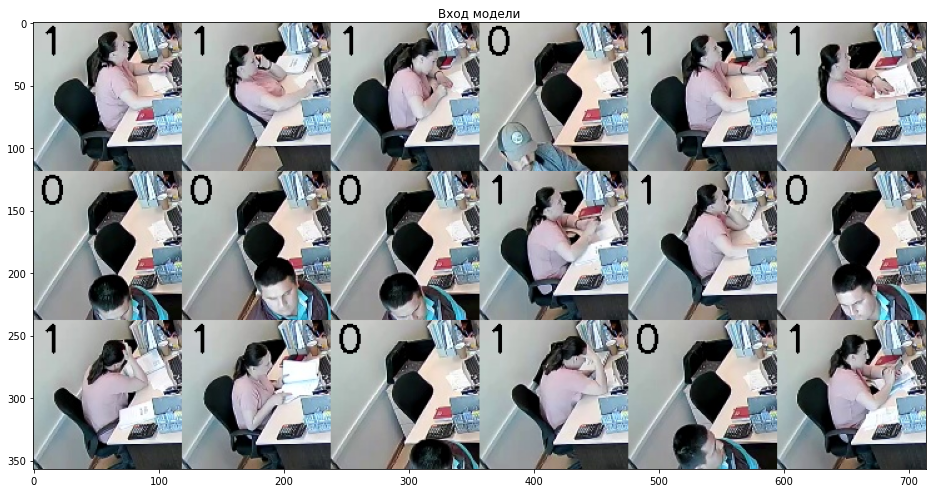

In [4]:
m, n = 3, 6
indices = iter(product(range(m), range(n)))
to_plot = np.zeros((119 * m, 119 * n, 3), dtype=np.uint8)
for X, y in valid_loader:
    i, j = next(indices)
    tmp_img = (X.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    tmp_img = cv2.putText(tmp_img, str(int(y.numpy()[0, 0])), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2);
    to_plot[i * 119 : (i + 1) * 119, j * 119 : (j + 1) * 119, :] = tmp_img.get()
    if i == 2 and j == 5:
        break

plt.figure(figsize=(16, 12))
plt.imshow(to_plot)
plt.title('Вход модели')
plt.show()



<b><h2><center>Подготовка Модели</center></h2></b>

In [5]:
class BinaryResnet(nn.Module):
    def __init__(self):
        super(BinaryResnet, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(512, 1, bias=True)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet.forward(x)
        x = self.activate(x)
        return x

model = BinaryResnet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<b><h2><center>Обучение</center></h2></b>

In [18]:
mean_train_loss, mean_valid_loss = [], []

In [22]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5 * 1e-8)
criterion = nn.BCELoss()
epochs = 7
for epoch in range(epochs):
    accuracy = 0
    train = iter(train_loader)
    valid = iter(valid_loader)
    tmp_train_loss, tmp_valid_loss = [], []
    for i in tqdm(range(len(train))):
        optimizer.zero_grad()
    # Forward
        X, y = next(train)
        X, y = X.to(device), y.to(device)
        y_pred = model.forward(X)
        

    # Calculate loss
        loss = criterion(y_pred, y)

    # Backward
        loss.backward()

    # Update weigths
        optimizer.step()

    # Validation
        with torch.no_grad():
            X_valid, y_valid = next(valid)
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            y_valid_pred = model.forward(X_valid)
            loss_valid = criterion(y_valid_pred, y_valid)
    # Udpate metrics
            tmp_train_loss.append(loss.item())
            tmp_valid_loss.append(loss_valid.item())

            tmp_pred = 1 if y_valid_pred >= 0.5 else 0
            if tmp_pred == y_valid:
                accuracy += 1

    torch.cuda.empty_cache()
    train_loss = sum(tmp_train_loss) / len(tmp_train_loss)
    valid_loss = sum(tmp_valid_loss) / len(tmp_valid_loss)
    mean_train_loss.append(train_loss)
    mean_valid_loss.append(valid_loss)
    print(f'epoch: {epoch + 1}, train loss: {train_loss}', 
    f'valid loss = {valid_loss}, acc: {accuracy /len(train)}')

    
        

  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 1, train loss: 7.632883329447198e-06 valid loss = 0.01430544466542863, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 2, train loss: 0.00030931441586375905 valid loss = 0.013191636766904317, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 3, train loss: 3.0008482508554093e-06 valid loss = 0.012857057971194845, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 4, train loss: 8.601360362844424e-06 valid loss = 0.013860044713668607, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 5, train loss: 2.9942668877423046e-06 valid loss = 0.012552007315326076, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 6, train loss: 0.00010095346384049122 valid loss = 0.01213424327400297, acc: 1.0


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 7, train loss: 0.0011356066080208309 valid loss = 0.012876033997230663, acc: 1.0


<b><h2><center>Метрики</center></h2></b>

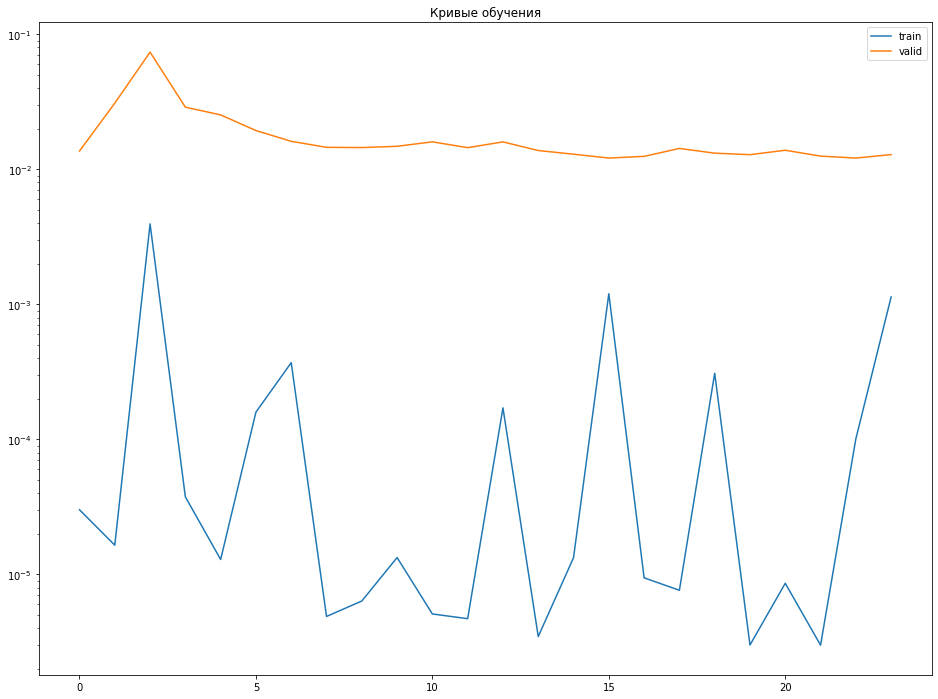

In [25]:
plt.figure(figsize=(16, 12))
plt.plot(mean_train_loss)
plt.plot(mean_valid_loss)
plt.title('Кривые обучения')
plt.yscale('log')
plt.legend(['train', 'valid'])
plt.show()

In [26]:
torch.save(model.state_dict(), 'model_weights.pth')

In [40]:
model.eval()
acc = 0
y_list, y_pred_list = [], []
with torch.no_grad():
    valid = iter(valid_loader)
    for _ in tqdm(range(len(valid_loader))):
        X, y = next(valid)
        X, y = X.to(device), y.to(device)

        y_pred = model.forward(X)

        y_pred_tmp = y_pred.cpu().numpy()[0][0]
        y_tmp = y.cpu().numpy()[0][0]
        
        y_pred_tmp = 1 if y_pred_tmp > 0.5 else 0

        if y_tmp == y_pred_tmp:
            acc += 1

print(f'Accuracy: {acc / len(valid_loader)}')

  0%|          | 0/1468 [00:00<?, ?it/s]

Accuracy: 1.0
